# Make a model based on past diagnoses that predicts the optimal drug for future patients

Accompanying YouTube video: https://youtu.be/OnQ_hdjnRrQ

I wanted to do something medical with ML, but I couldn't see how to apply regression to any such datasets outside of diagnosis, except imaging.  Since we won't be covering the application of ML to image recognition until the ML course, I eschewed those projects.  So I settled on a regression problem in which the correct drug recommendations for 200 people with the same disease.

The project comes from the dataset site Kaggle.  The dataset has only 200 records.  The independent variables are age, blood pressure, gender, sodium-to-potassium blood ratio, and cholesterol level.  (The cholesterol level is just a binary variable, either high or normal.)  The dependent variable is the drug (of five) found to be effective for that patient.

**Anticipated difficulties:** Drug, our discrete dependent variable, is *not* ordinal.  This variable isn't a variation in dosage.  It's a qualitative difference in drug type.  So this problem doesn't lend itself to multivariate linear regression.  This means using ML.
Some background: https://www.quora.com/Why-can-we-not-use-linear-regression-for-an-ordinal-dependent-variable
Solutions other than ML when the dependent variable has more than two levels (thus ruling out logistic) include MLE and multinomial logistic regression.
Some background:
* https://www.researchgate.net/post/How_to_predict_nominal_dependent_given_categorical_independent_variables
* https://en.wikipedia.org/wiki/Multinomial_logistic_regression


Data source:
https://www.kaggle.com/prathamtripathi/drug-classification

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
import math

In [2]:
df = pd.read_csv('drug200.csv')

In [3]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [4]:
df.dtypes

Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
Drug            object
dtype: object

Before changing Drug to categorical must change spelling to be homogeneous.  (We can't change a record's category value *after* the variable is set to category type, since a new category would, therefore, be created.)

In [5]:
drugy = df.Drug == 'DrugY'
df.loc[drugy,['Drug']] = 'drugY'

In [6]:
df.Sex = df.Sex.astype('category')
df.BP = df.BP.astype('category')
df.Cholesterol = df.Cholesterol.astype('category')
df.Drug = df.Drug.astype('category')

In [7]:
df.dtypes

Age               int64
Sex            category
BP             category
Cholesterol    category
Na_to_K         float64
Drug           category
dtype: object

### Data Scrubbing ###
It was confirmed in Excel that there are only five spellings of the dependent variable, Drug, and only DrugY uses a capitalization.  Other variables were checked to ensure no multiplicity of spellings for the same intended value.  No data was missing.

In [8]:
drugy = df.Drug == 'DrugY'
df.loc[drugy,['Drug']] = 'drugY'


In [9]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


Excel analysis shows there are no NaNs.

### EDA

Check for outliers:

In [10]:
drug_a=df.loc[df['Drug']=='drugA'].values    # data frames from data frames
drug_b=df.loc[df['Drug']=='drugB'].values
drug_c=df.loc[df['Drug']=='drugC'].values
drug_x=df.loc[df['Drug']=='drugX'].values
drug_y=df.loc[df['Drug']=='drugY'].values

a=drug_a[:,0:1]      # numpy vector from a pandas data frame column
b=drug_b[:,0:1]
c=drug_c[:,0:1]
x=drug_x[:,0:1]
y=drug_y[:,0:1]

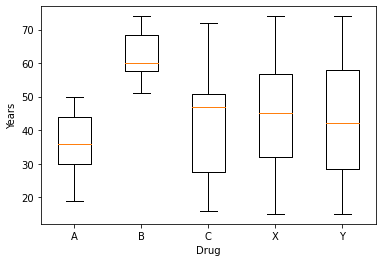

In [11]:
#fig, ax = plt.subplots() # 1 row, 5 columns
#plt.boxplot([drug_a, drug_b, drug_c, drug_x, drug_y], labels=['A','B','C','X','Y'])
#plt.boxplot([drug_a], labels=['A'])
# plt.boxplot([drug_a])
# plt.ylabel('Years')
# plt.xlabel('Drug')
#plt.show();
# How to fit these plots onto one row?

# fig, ax = plt.subplots(1, 5) # 1 row, 5 columns
# plt.boxplot([drug_a, drug_b, drug_c, drug_x, drug_y], labels=['A','B','C','X','Y'])
# plt.ylabel('Years')
# plt.xlabel('Drug')
# plt.show()

data1 = [a.flatten(), b.flatten(), c.flatten(), x.flatten(), y.flatten()]  # b/c they're 2D
fig, ax = plt.subplots()
ax.boxplot(data1, labels=['A','B','C','X','Y'])
plt.ylabel('Years')
plt.xlabel('Drug')
plt.show();

# fig1, ax1 = plt.subplots()
# ax1.set_title('Drug A')
# ax1.boxplot(a);






Three drugs seem appropriate for all age ranges, while B doesn't seem to work for those under 50 at all and A doesn't work for anyone over 50.
So what other patterns could be noticed by examining other variables?

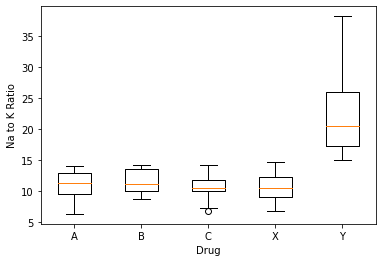

In [12]:


a_NatoK=drug_a[:,4:5]      # numpy vector from a pandas data frame column
b_NatoK=drug_b[:,4:5]
c_NatoK=drug_c[:,4:5]
x_NatoK=drug_x[:,4:5]
y_NatoK=drug_y[:,4:5]

data2 = [a_NatoK.flatten(), b_NatoK.flatten(), c_NatoK.flatten(), x_NatoK.flatten(), y_NatoK.flatten()]  # b/c they're 2D
fig, ax = plt.subplots()
ax.boxplot(data2, labels=['A','B','C','X','Y'])
plt.ylabel('Na to K Ratio')
plt.xlabel('Drug')
plt.show();

Clearly drug Y is the one and only drug of choicewhen the Na-to-K ratio is above 15.

Y has quite a spread.  I might suspect that a histogram should be run to see if there are outliers, especially since parameters estimated by MLE, which is used for multinomial logistic regression, is highly susceptible to outliers.  However, the outliers for Y seem to go in a direction that would ensure that drug Y is prescribed if the Na:K ratio is over 15.

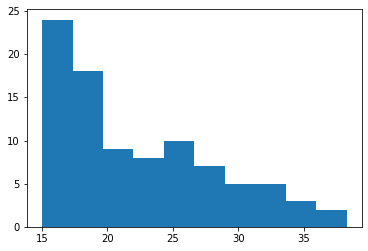

In [13]:
plt.hist(y_NatoK);
plt.show;

This looks pretty smooth.  No reason to remove any data at the high end.

In [14]:
#df.columns[0]

In [15]:
# df_gender_wrong = df_gender.groupby(['Sex', 'Drug'])['id'].count().reset_index(name='count')

#df_gender_wrong = df.loc(,['Sex','Drug'], as_index=False).count()

# df1.groupby(['State','Product'])['Sales'].count().reset_index() # to model from another source
df_gender_wrong = df.groupby(['Sex'])['Drug'].count().reset_index()
df_gender_wrong
# So now I can't replicate my problem for discussion.

,Sex,Drug
0,F,96
1,M,104


In [16]:

df_gender = df[['Sex', 'Drug']].copy()   # to avoid other cols showing up in results
df_gender = df_gender.groupby(['Sex','Drug']).Drug.agg('count').to_frame('c').reset_index()
df_gender



,Sex,Drug,c
0,F,drugA,9
1,F,drugB,6
2,F,drugC,7
3,F,drugX,27
4,F,drugY,47
5,M,drugA,14
6,M,drugB,10
7,M,drugC,9
8,M,drugX,27
9,M,drugY,44


In [17]:
#df_gender

In [18]:


df_gender = df_gender.pivot_table(index='Sex',columns='Drug',values='c',fill_value=0)
df_gender


Drug,drugA,drugB,drugC,drugX,drugY
Sex,,,,,
F,9,6,7,27,47
M,14,10,9,27,44


<Figure size 432x288 with 0 Axes>

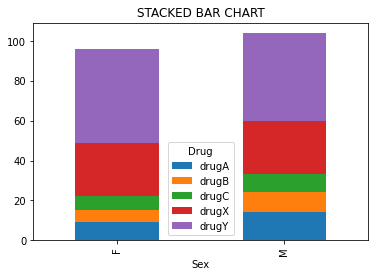

In [19]:
# df_gender[["Drug"]].plot(kind="bar", stacked=True)
# df_gender['Sex'].plot(kind='bar', stacked=True)

plt.figure();
df_gender.plot.bar(title='STACKED BAR CHART', stacked=True);


There's no significant difference between genders.  Gender is likely a variable that can be dropped.

<Figure size 432x288 with 0 Axes>

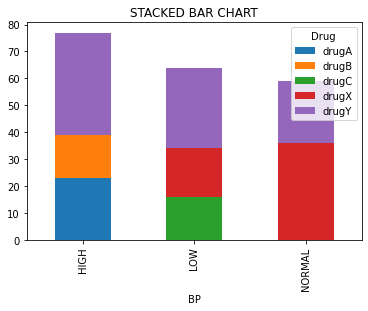

In [20]:
df_BP = df[['BP', 'Drug']].copy()   # to avoid other cols showing up in results
df_BP = df_BP.groupby(['BP','Drug']).Drug.agg('count').to_frame('c').reset_index()
df_BP = df_BP.pivot_table(index='BP',columns='Drug',values='c',fill_value=0)
plt.figure();
df_BP.plot.bar(title='STACKED BAR CHART', stacked=True);

This result is distinctive.  For each blood pressure category, at least two drugs are deemed
relatively ineffective.  For normal blood pressure, three medications are deemed inferior.  Drug
X an C are never given to those with high blood pressure.

<Figure size 432x288 with 0 Axes>

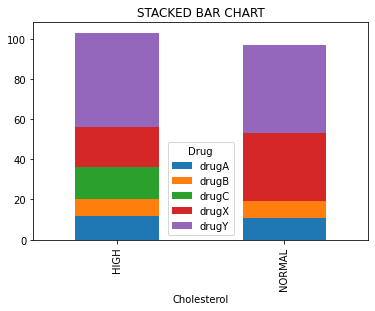

In [21]:
df_chol = df[['Cholesterol', 'Drug']].copy()   # to avoid other cols showing up in results
df_chol = df_chol.groupby(['Cholesterol','Drug']).Drug.agg('count').to_frame('c').reset_index()
df_chol = df_chol.pivot_table(index='Cholesterol',columns='Drug',values='c',fill_value=0)
plt.figure();
df_chol.plot.bar(title='STACKED BAR CHART', stacked=True, );

Drug C isn't given to those with normal cholesterol.  X seems preferred.  Otherwise, 
the differences don't seem significant.

### Sample Size ###
Schwab (2002) advises that a multinomial logistic regression requires a sample size of at least 10 records per independent variable.  With 200 records, this criterion is met.
https://it.unt.edu/sites/default/files/mlr_jds_aug2011.pdf

### EDA Summary ###
I could find no missing data or outliers, the latter being of concern for the MLE approach I'm likely to use for multinomial logistic regression.  The sample is of sufficient size.
I will expect my model to have certain properties that match patterns found in the EDA:
* Drug C won't be prescribed if cholesterol is normal.
* Drugs A, B, and C won't be prescribed if blood pressure is normal.
* Drugs A and B won't be used if blood pressure is low.
* Drugs C and X won't be prescribed if blood pressure is high.
* Drug Y is prescribed if and only if blood Na:K ratio is above 15.  No other drug is prescribed then.  Y is not prescribed in any other situation.
* Drug A should be prescribed only to patients under 50.  Drug B should only be prescribed to patients over 50.

If the model fails to meet any of these criteria, it should be treated as suspect.

Gender might be a superfluous factor worth removing to improve the record-to-independent variable ratio.  Note that it does not figure into any of the above rules.

Curiously, high and low cholesterol receive the same treatment.  This is a little suspicious, and perhaps hints at a covariance.

# Test Data
An interesting point to note is that the above criteria leave little to chance.  So we can make up test data for which we know the answer.

Age=55, low BP, normal chol, Na:K<15 --> Drug X

Age=55, low BP, normal chol, Na:K>15 --> Drug Y

Age=40, high BP, high chol, Na:K<15 --> Drug A

Age=40, high BP, low chol, Na:K<15 --> Drug A

Age=40, normal BP, low chol, Na:K<15 --> Drug X

Age=60, low BP, high chol, Na:K<15 --> Drug C or X

Age=60, low BP, normal chol, Na:K<15 --> Drug A or X


The above could be used for testing our draft model.

The solutions are not completely unique.

In [22]:
from sklearn.linear_model import LogisticRegression

In order to use this package, the discrete features must be transformed, represented by dummy variables, for one-versus-the-rest analysis (OVR), as discussed in lecture.  The outputs do not need to be transformed: LogisticRegression has a multiclass feature. So I bother specifying which columns need transformation instead of leaving the default to modify the dependent variable as well.

In [57]:
df_OVR = pd.get_dummies(df,columns=['Sex','BP','Cholesterol'])

In [58]:
df_OVR

,Age,Na_to_K,Drug,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL
0,23,25.355,drugY,1,0,1,0,0,1,0
1,47,13.093,drugC,0,1,0,1,0,1,0
2,47,10.114,drugC,0,1,0,1,0,1,0
3,28,7.798,drugX,1,0,0,0,1,1,0
4,61,18.043,drugY,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
195,56,11.567,drugC,1,0,0,1,0,1,0
196,16,12.006,drugC,0,1,0,1,0,1,0
197,52,9.894,drugX,0,1,0,0,1,1,0
198,23,14.020,drugX,0,1,0,0,1,0,1


As can be seen, this creates redundant dummy variables.  Male is represented both by Sex_F=0 and Sex_M=1.  We can drop some three columns.

In [66]:
#new = old.drop('B', axis=1) 
df_OVR2 = df_OVR.drop(['Sex_M', 'BP_NORMAL', 'Cholesterol_NORMAL'], axis=1)   # list-like

In [62]:
df_OVR2

,Age,Na_to_K,Drug,Sex_F,BP_HIGH,BP_LOW,Cholesterol_HIGH
0,23,25.355,drugY,1,1,0,1
1,47,13.093,drugC,0,0,1,1
2,47,10.114,drugC,0,0,1,1
3,28,7.798,drugX,1,0,0,1
4,61,18.043,drugY,1,0,1,1
...,...,...,...,...,...,...,...
195,56,11.567,drugC,1,0,1,1
196,16,12.006,drugC,0,0,1,1
197,52,9.894,drugX,0,0,0,1
198,23,14.020,drugX,0,0,0,0


In [67]:
df_OVR2 = df_OVR2[['Age','Na_to_K','Sex_F','BP_HIGH','BP_LOW','Cholesterol_HIGH','Drug']]

In [68]:
df_OVR2

,Age,Na_to_K,Sex_F,BP_HIGH,BP_LOW,Cholesterol_HIGH,Drug
0,23,25.355,1,1,0,1,drugY
1,47,13.093,0,0,1,1,drugC
2,47,10.114,0,0,1,1,drugC
3,28,7.798,1,0,0,1,drugX
4,61,18.043,1,0,1,1,drugY
...,...,...,...,...,...,...,...
195,56,11.567,1,0,1,1,drugC
196,16,12.006,0,0,1,1,drugC
197,52,9.894,0,0,0,1,drugX
198,23,14.020,0,0,0,0,drugX


In [71]:
x=df_OVR2.iloc[:,0:6]      # numpy vector from a pandas data frame; all rows, first n-1 columns
y=df_OVR2.iloc[:,6:7]      # all rows, last col
Y=y.to_numpy()
X=x.to_numpy()
Y=Y.flatten()     # so it's no longer 2-dimensional (X must stay 2-d, of course)



Now to use first 100 for training and second 100 for testing.

In [72]:
X_train = X[0:100,:]
Y_train = Y[0:100]
X_test = X[100:201,:]
Y_test = Y[100:201]

I'm using the default solver here, lbfgs, since it is one of the solvers available in the package that supports the multinomial option.  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [75]:
drug_fit = LogisticRegression(multi_class='multinomial').fit(X_train, Y_train)


/Users/User/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array(['drugA', 'drugA', 'drugY', 'drugX', 'drugY', 'drugX', 'drugX',
       'drugY', 'drugB', 'drugY'], dtype=object)

In [76]:
drug_fit.predict(X_test[:,:])

array(['drugA', 'drugA', 'drugY', 'drugX', 'drugY', 'drugX', 'drugX',
       'drugY', 'drugB', 'drugY', 'drugB', 'drugX', 'drugX', 'drugX',
       'drugX', 'drugY', 'drugX', 'drugX', 'drugA', 'drugY', 'drugY',
       'drugY', 'drugY', 'drugY', 'drugB', 'drugY', 'drugB', 'drugX',
       'drugY', 'drugX', 'drugY', 'drugY', 'drugX', 'drugY', 'drugY',
       'drugX', 'drugB', 'drugA', 'drugB', 'drugX', 'drugB', 'drugY',
       'drugB', 'drugB', 'drugA', 'drugX', 'drugX', 'drugA', 'drugX',
       'drugC', 'drugB', 'drugB', 'drugX', 'drugX', 'drugY', 'drugC',
       'drugA', 'drugY', 'drugC', 'drugY', 'drugX', 'drugB', 'drugX',
       'drugY', 'drugY', 'drugY', 'drugY', 'drugX', 'drugY', 'drugA',
       'drugY', 'drugX', 'drugY', 'drugY', 'drugA', 'drugY', 'drugB',
       'drugY', 'drugY', 'drugY', 'drugY', 'drugX', 'drugY', 'drugY',
       'drugY', 'drugY', 'drugB', 'drugB', 'drugY', 'drugY', 'drugY',
       'drugA', 'drugY', 'drugC', 'drugY', 'drugC', 'drugY', 'drugX',
       'drugY', 'dru

In [74]:
Y_test

array(['drugA', 'drugA', 'drugC', 'drugX', 'drugY', 'drugX', 'drugX',
       'drugY', 'drugB', 'drugY', 'drugA', 'drugX', 'drugX', 'drugX',
       'drugX', 'drugY', 'drugX', 'drugX', 'drugA', 'drugY', 'drugY',
       'drugY', 'drugY', 'drugY', 'drugB', 'drugY', 'drugY', 'drugX',
       'drugY', 'drugX', 'drugY', 'drugY', 'drugX', 'drugY', 'drugY',
       'drugX', 'drugB', 'drugA', 'drugB', 'drugX', 'drugA', 'drugY',
       'drugB', 'drugY', 'drugA', 'drugX', 'drugX', 'drugA', 'drugX',
       'drugC', 'drugA', 'drugB', 'drugX', 'drugX', 'drugY', 'drugC',
       'drugA', 'drugY', 'drugC', 'drugX', 'drugX', 'drugB', 'drugX',
       'drugY', 'drugY', 'drugY', 'drugY', 'drugX', 'drugY', 'drugA',
       'drugX', 'drugX', 'drugY', 'drugY', 'drugA', 'drugY', 'drugA',
       'drugY', 'drugY', 'drugY', 'drugY', 'drugX', 'drugX', 'drugY',
       'drugY', 'drugY', 'drugB', 'drugA', 'drugY', 'drugY', 'drugY',
       'drugA', 'drugY', 'drugC', 'drugY', 'drugC', 'drugC', 'drugX',
       'drugX', 'dru

So our testing data produces 89% success rate.  How serious are the differences?  Do any of the 11 discrepancies violate any of our six rules that we saw in the box-and-whiskers plots?

In [90]:
list1=[102,110,126,140,143,150,170,176,182,187,196,198]
df_OVR2.loc[list1]

,Age,Na_to_K,Sex_F,BP_HIGH,BP_LOW,Cholesterol_HIGH,Drug
102,28,13.127,1,0,1,1,drugC
110,50,7.490,0,1,0,1,drugA
126,66,16.347,0,1,0,1,drugY
140,49,6.269,0,1,0,0,drugA
143,74,15.436,0,1,0,0,drugY
150,49,8.700,0,1,0,0,drugA
170,28,12.879,1,0,0,1,drugX
176,48,10.446,0,1,0,0,drugA
182,20,11.686,1,0,1,0,drugX
187,47,10.403,0,1,0,1,drugA


In [89]:
list2=[2,10,26,40,43,50,70,76,82,87,96,98]
X_test2 = X_test[list2]
X_test2

array([[28.   , 13.127,  1.   ,  0.   ,  1.   ,  1.   ],
       [50.   ,  7.49 ,  0.   ,  1.   ,  0.   ,  1.   ],
       [66.   , 16.347,  0.   ,  1.   ,  0.   ,  1.   ],
       [49.   ,  6.269,  0.   ,  1.   ,  0.   ,  0.   ],
       [74.   , 15.436,  0.   ,  1.   ,  0.   ,  0.   ],
       [49.   ,  8.7  ,  0.   ,  1.   ,  0.   ,  0.   ],
       [28.   , 12.879,  1.   ,  0.   ,  0.   ,  1.   ],
       [48.   , 10.446,  0.   ,  1.   ,  0.   ,  0.   ],
       [20.   , 11.686,  1.   ,  0.   ,  1.   ,  0.   ],
       [47.   , 10.403,  0.   ,  1.   ,  0.   ,  1.   ],
       [16.   , 12.006,  0.   ,  0.   ,  1.   ,  1.   ],
       [23.   , 14.02 ,  0.   ,  0.   ,  0.   ,  0.   ]])

In [88]:
drug_fit.predict(X_test2[:,:])

array(['drugY', 'drugB', 'drugB', 'drugB', 'drugB', 'drugB', 'drugY',
       'drugB', 'drugY', 'drugB', 'drugY', 'drugY'], dtype=object)

So we see a pattern.  All the incorrect predictions are Y and B.  
If we review our rules from earlier, Y should be given only if the Na:K ratio is at least 15.  So this rule that we picked up on earlier is being violated.
What about all these predictions for B?  Did we establish a rule against those?
Predicting B is okay here in terms of blood pressure.  (Our rule was that B should only be prescribed if BP is high.)
In terms of age, our 50-year-old cutoff was violated only for index 150.
So there's nothing here to strongly preclude these drug B predictions.  
But two patients were predicted to need B when their Na:K is above 15 (indices 126 and 143).  So we're right back to the trouble with Y again.
I think the incorrect B predictions are just because the model is underdetermined.  An additional feature is likely needed.

Next steps? Run more iterations, remove gender, or run a model with interactions.  An interactions model might be the best bet, since one variable (Na:K) taking precedence over all others is above a certain value is not something that lends itself to a model with several features.  We'd have to leave behind sklearn for patsy, though.

Before we rerun the above without gender, can we perform a diagnostic that supports such a move?

In [91]:
drug_fit.score(X_train, Y_train)

0.95

The score method in sklearn.linear_model.LogisticRegression returns accuracy.  
https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

So our training accuracy was 95% while our test accuracy was 89%.

In [94]:
from sklearn import metrics

In [95]:
metrics.confusion_matrix(Y_test, drug_fit.predict(X_test[:,:]))

array([[10,  5,  0,  0,  0],
       [ 0,  8,  0,  0,  0],
       [ 0,  0,  5,  0,  2],
       [ 0,  0,  0, 26,  4],
       [ 0,  2,  0,  0, 38]])

This seems to say the accuracy for the test data was actually only 87%, so I missed two discrepancies in the predictions.
https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

sklearn LogisticRegression doesn't have a built-in p-value function, so I'll instead just pull out gender to see if accuracy improves.  While doing this, I'll increase the number of iterations and randomize the testing and training data.  Of course, then I'm not really comparing with and without gender fairly, but when the model's this explanatory, 3-4 explanatory variables is considered sufficient, especially with support from the EDA.

In [96]:
df_OVR3 = df_OVR2[['Age','Na_to_K','BP_HIGH','BP_LOW','Cholesterol_HIGH','Drug']]

Before I pull off independent and dependent columns, thus separating them, I need to pull off rows randomly.  If I split up the ind't and dep't columns first, then I don't know that the same rows will be randomly pulled off, nor in what order, and so I couldn't match input to output.

In [127]:
test_rand = df_OVR3.sample(n = 100)
train_rand = df_OVR3.sample(n = 100)

In [128]:
test_rand

,Age,Na_to_K,BP_HIGH,BP_LOW,Cholesterol_HIGH,Drug
113,65,13.769,0,1,0,drugX
42,50,15.790,0,0,0,drugY
80,60,13.934,1,0,1,drugB
53,24,18.457,1,0,0,drugY
69,18,24.276,1,0,0,drugY
...,...,...,...,...,...,...
7,41,11.037,0,1,1,drugC
73,41,22.905,0,0,0,drugY
122,34,22.456,0,0,1,drugY
75,26,20.909,0,1,0,drugY


The previous error message with respect to convergence suggested scaling.  Perhaps lack of scaling inhibited proper processing of drug Y as having a significant cutoff at an Na:K ratio of 50.

In [129]:
print(train_rand['Age'].mean());
print(train_rand['Age'].std());

45.46
16.18480394653821


In [130]:
train_rand['Age']=(train_rand['Age']-45)/15

In [131]:
train_rand

,Age,Na_to_K,BP_HIGH,BP_LOW,Cholesterol_HIGH,Drug
9,-0.133333,19.368,0,1,0,drugY
36,-0.866667,9.445,1,0,0,drugA
150,0.266667,8.700,1,0,0,drugA
123,-0.600000,16.753,0,0,1,drugY
38,-0.400000,9.709,0,0,0,drugX
...,...,...,...,...,...,...
169,-1.666667,11.262,1,0,1,drugA
137,-0.666667,12.894,1,0,1,drugA
39,-2.000000,9.084,0,0,1,drugX
88,-0.533333,23.091,1,0,0,drugY


In [132]:
test_rand['Age']=(test_rand['Age']-45)/15

In [133]:
print(train_rand['Na_to_K'].mean());
print(train_rand['Na_to_K'].std());

15.465710000000001
6.629633788345762


In [134]:
train_rand['Na_to_K']=(train_rand['Na_to_K']-15)/7
test_rand['Na_to_K']=(test_rand['Na_to_K']-15)/7

In [136]:
train_rand


,Age,Na_to_K,BP_HIGH,BP_LOW,Cholesterol_HIGH,Drug
9,-0.133333,0.624000,0,1,0,drugY
36,-0.866667,-0.793571,1,0,0,drugA
150,0.266667,-0.900000,1,0,0,drugA
123,-0.600000,0.250429,0,0,1,drugY
38,-0.400000,-0.755857,0,0,0,drugX
...,...,...,...,...,...,...
169,-1.666667,-0.534000,1,0,1,drugA
137,-0.666667,-0.300857,1,0,1,drugA
39,-2.000000,-0.845143,0,0,1,drugX
88,-0.533333,1.155857,1,0,0,drugY


In [137]:
test_rand

,Age,Na_to_K,BP_HIGH,BP_LOW,Cholesterol_HIGH,Drug
113,1.333333,-0.175857,0,1,0,drugX
42,0.333333,0.112857,0,0,0,drugY
80,1.000000,-0.152286,1,0,1,drugB
53,-1.400000,0.493857,1,0,0,drugY
69,-1.800000,1.325143,1,0,0,drugY
...,...,...,...,...,...,...
7,-0.266667,-0.566143,0,1,1,drugC
73,-0.266667,1.129286,0,0,0,drugY
122,-0.733333,1.065143,0,0,1,drugY
75,-1.266667,0.844143,0,1,0,drugY


In [138]:
# x=df_OVR2.iloc[:,0:6]      # numpy vector from a pandas data frame; all rows, first n-1 columns
# y=df_OVR2.iloc[:,6:7]      # all rows, last col
# Y=y.to_numpy()
# X=x.to_numpy()
# Y=Y.flatten()     # so it's no longer 2-dimensional (X must stay 2-d, of course)

# X_train = X[0:100,:]
# Y_train = Y[0:100]
# X_test = X[100:201,:]
# Y_test = Y[100:201]

x_train_rand = train_rand.iloc[:,0:5]    # df to df
y_train_rand = train_rand.iloc[:,5:6]
x_test_rand = test_rand.iloc[:,0:5]      
y_test_rand = test_rand.iloc[:,5:6]

X_train_rand_np = x_train_rand.to_numpy()     # df to np array
Y_train_rand_np = y_train_rand.to_numpy()
X_test_rand_np = x_test_rand.to_numpy()
Y_test_rand_np = y_test_rand.to_numpy()

Y_train_rand_np = Y_train_rand_np.flatten()     # make Y one-dimensional
Y_test_rand_np = Y_test_rand_np.flatten()

Default maximum number of iterations, which we used above, is only 100.  That wasn't enough to achieve convergence. 

In [139]:
drug_fit_rand = LogisticRegression(multi_class='multinomial', max_iter=1000).fit(X_train_rand_np, Y_train_rand_np)

In [140]:
drug_fit_rand.score(X_train_rand_np, Y_train_rand_np)

0.96

So I've achieved convergence, but the accuracy of the training isn't much improved.

In [142]:
metrics.confusion_matrix(Y_test_rand_np, drug_fit_rand.predict(X_test_rand_np[:,:]))

array([[ 9,  0,  0,  0,  0],
       [ 1,  5,  0,  0,  3],
       [ 0,  0, 10,  0,  0],
       [ 0,  0,  0, 21,  1],
       [ 1,  0,  0,  0, 49]])

The test accuracy is 94%--far better than the 87% of before!
Now let's burrow down and see if there's any pattern in the discrepancies, like before.

Removing gender while also solving the convergence problem via regularization and randomizing the training data isn't very scientific.  We don't know if dropping gender increased testing accuracy, or if it even went up _despite_ removal of gender.  

For the sake of being scientific about the removal of gender, let's add gender back in, with convergence and random sampling, and see what the accuracy is.

In [146]:
df_OVR4 = df_OVR2[['Age','Sex_F','Na_to_K','BP_HIGH','BP_LOW','Cholesterol_HIGH','Drug']]

In [147]:
test_rand_MF = df_OVR4.sample(n = 100)
train_rand_MF = df_OVR4.sample(n = 100)

In [149]:
train_rand_MF['Age']=(train_rand_MF['Age']-45)/15    # regularization, to effect convergence
test_rand_MF['Age']=(test_rand_MF['Age']-45)/15

train_rand_MF['Na_to_K']=(train_rand_MF['Na_to_K']-15)/7
test_rand_MF['Na_to_K']=(test_rand_MF['Na_to_K']-15)/7

In [150]:
x_train_rand_MF = train_rand_MF.iloc[:,0:6]    # df to df
y_train_rand_MF = train_rand_MF.iloc[:,6:7]
x_test_rand_MF = test_rand_MF.iloc[:,0:6]      
y_test_rand_MF = test_rand_MF.iloc[:,6:7]

X_train_rand_np_MF = x_train_rand_MF.to_numpy()     # df to np array
Y_train_rand_np_MF = y_train_rand_MF.to_numpy()
X_test_rand_np_MF = x_test_rand_MF.to_numpy()
Y_test_rand_np_MF = y_test_rand_MF.to_numpy()

Y_train_rand_np_MF = Y_train_rand_np_MF.flatten()     # make Y one-dimensional
Y_test_rand_np_MF = Y_test_rand_np_MF.flatten()

In [151]:
drug_fit_rand_MF = LogisticRegression(multi_class='multinomial', max_iter=1000).fit(X_train_rand_np_MF, Y_train_rand_np_MF)

In [152]:
drug_fit_rand_MF.score(X_train_rand_np_MF, Y_train_rand_np_MF)   # accuracy of training

0.98

In [154]:
metrics.confusion_matrix(Y_test_rand_np_MF, drug_fit_rand_MF.predict(X_test_rand_np_MF[:,:]))

array([[16,  0,  0,  0,  0],
       [ 0,  6,  0,  0,  0],
       [ 0,  0,  6,  0,  0],
       [ 0,  0,  0, 29,  1],
       [ 0,  0,  0,  0, 42]])

So the accuracy for training data is 98% and for testing data is even higher: 99%!  It looks like my removal of gender was premature.

### Continued Analysis of Non-gendered Data ###
I include the following from the data without gender only since I have it.  It's somewhat interesting what happens when gender is left out, but can be skipped.

In [143]:
drug_fit_rand.predict(X_test_rand_np[:,:])

array(['drugX', 'drugY', 'drugY', 'drugY', 'drugY', 'drugY', 'drugY',
       'drugY', 'drugB', 'drugY', 'drugX', 'drugY', 'drugY', 'drugX',
       'drugX', 'drugY', 'drugX', 'drugA', 'drugY', 'drugY', 'drugC',
       'drugA', 'drugY', 'drugY', 'drugC', 'drugY', 'drugX', 'drugC',
       'drugY', 'drugX', 'drugY', 'drugY', 'drugC', 'drugX', 'drugY',
       'drugY', 'drugX', 'drugY', 'drugY', 'drugX', 'drugY', 'drugB',
       'drugX', 'drugY', 'drugX', 'drugY', 'drugY', 'drugY', 'drugX',
       'drugB', 'drugB', 'drugA', 'drugX', 'drugY', 'drugX', 'drugC',
       'drugY', 'drugA', 'drugX', 'drugY', 'drugB', 'drugA', 'drugX',
       'drugA', 'drugX', 'drugY', 'drugC', 'drugC', 'drugX', 'drugY',
       'drugY', 'drugY', 'drugY', 'drugY', 'drugA', 'drugY', 'drugY',
       'drugY', 'drugY', 'drugY', 'drugY', 'drugA', 'drugX', 'drugY',
       'drugY', 'drugX', 'drugA', 'drugY', 'drugY', 'drugA', 'drugA',
       'drugY', 'drugC', 'drugC', 'drugY', 'drugC', 'drugY', 'drugY',
       'drugY', 'dru

In [144]:
Y_test_rand_np

array(['drugX', 'drugY', 'drugB', 'drugY', 'drugY', 'drugX', 'drugY',
       'drugY', 'drugB', 'drugB', 'drugX', 'drugY', 'drugY', 'drugX',
       'drugX', 'drugY', 'drugX', 'drugA', 'drugY', 'drugY', 'drugC',
       'drugA', 'drugY', 'drugY', 'drugC', 'drugY', 'drugX', 'drugC',
       'drugY', 'drugX', 'drugY', 'drugY', 'drugC', 'drugX', 'drugY',
       'drugY', 'drugX', 'drugY', 'drugB', 'drugX', 'drugY', 'drugB',
       'drugX', 'drugY', 'drugX', 'drugY', 'drugY', 'drugY', 'drugX',
       'drugB', 'drugB', 'drugA', 'drugX', 'drugY', 'drugX', 'drugC',
       'drugY', 'drugA', 'drugX', 'drugY', 'drugB', 'drugA', 'drugX',
       'drugA', 'drugX', 'drugY', 'drugC', 'drugC', 'drugX', 'drugY',
       'drugY', 'drugY', 'drugY', 'drugY', 'drugY', 'drugY', 'drugY',
       'drugY', 'drugY', 'drugY', 'drugY', 'drugA', 'drugX', 'drugY',
       'drugY', 'drugX', 'drugA', 'drugY', 'drugY', 'drugB', 'drugA',
       'drugY', 'drugC', 'drugC', 'drugY', 'drugC', 'drugY', 'drugY',
       'drugY', 'dru

In [145]:
list3=[2,5,9,38,74,89]      # pulling off the rows with discrepancies b/n test-prediction and test-actual
X_test_rand_np_missed = X_test_rand_np[list3]
X_test_rand_np_missed

array([[ 1.        , -0.15228571,  1.        ,  0.        ,  1.        ],
       [ 1.8       , -0.05114286,  0.        ,  1.        ,  0.        ],
       [ 0.93333333, -0.15214286,  1.        ,  0.        ,  1.        ],
       [ 0.86666667, -0.10871429,  1.        ,  0.        ,  0.        ],
       [-2.        ,  0.24642857,  1.        ,  0.        ,  0.        ],
       [ 0.66666667, -0.57471429,  1.        ,  0.        ,  1.        ]])

Of all six missed predictions, only the last one didn't involve drug Y.  It involved a switch from B to A, breaking the age rule.  The age is (2/3)x15+45=55, and so should be B.

### Conclusions ###

While age didn't seem to play a role in our initial analysis, subsequent analysis shows it does play a role.  It seemed like a flowchart could outperform the genderless model, with the complication of drug Y having a hard and fast Na:K cutoff, but all that was needed was to reinclude gender.

Regularization solved the convergence problem and improved testing results tremendously.  The non-gendered fit led me to believe the data wasn't sufficiently determined for a model to choose between A, B, and C correctly, and that gender was not a path to sufficient determination, but that proved not to be the case.

Since the confusion matrix isn't 2x2, I didn't have the luxury of using, say, the F1 metric.  The accuracy is so high, that I don't see what other metrics could add.

### Further Study ###

For the next step after running the genderless model, I thought of adding interactions into the model using patsy.  But since adding gender gave such an improvement, I don't see the need.  Perhaps measures of fit other than accuracy could be applied to verify success.